In [1]:
import pandas as pd
train_dir='/content/xray_dataset_covid19/train'
test_dir='/content/xray_dataset_covid19/test'

In [2]:
rm -rf `find -type d -name .ipynb_checkpoints`  #TO REMOVE.IPYNB CHECKPOINTS


In [3]:
import os
classes_train=os.listdir(train_dir)
classes_test=os.listdir(test_dir)

In [4]:
print(classes_train)

['PNEUMONIA', 'NORMAL']


In [5]:
print(classes_test)

['PNEUMONIA', 'NORMAL']


7. Data Augmentation

We need to know what is the data augmentation Datat augmentation means generate new data from exisiting data. We do this because the performance of deep learning neural networks often improves with the amount of data available. In this example the data was small so we use this

In [6]:
# First for Training data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1.0/255.0, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1 #Shear angle in counter-clockwise direction in degrees
)
train_generator=train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(1000,1000,3)[:2]
)

Found 146 images belonging to 2 classes.


In [7]:
# Second for Testing data
test_datagen=ImageDataGenerator(
    rescale=1.0/255.0
)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(1000,1000,3)[:2]
)

Found 40 images belonging to 2 classes.


Callbacks

Callbacks is a method we use it to reduce over fiting and to save time. We will use EarlyStopping to stop the training process if the accuracy dose not improved for 5 times. ReduceLROnPlateau to minimize learning rate if the accuracy dose not improved for 2 times

In [8]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.001
)

Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
label_dict = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
    
}
model=Sequential() 


model.add(Conv2D(32,(5,5),activation='relu',input_shape=(1000,1000,3)))
# 16 is the number of filters, (3,3) it the filter size,acitivation is the activation function and input_shape is the size of the image 
model.add(MaxPooling2D(5,5))
#(2,2) is the pool size 

model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(5,5))


model.add(Conv2D(128,(5,5),activation='relu'))
model.add(MaxPooling2D(5,5))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
# 128 is the number of the hideen layers
model.add(Dropout(0.5))
# Dropout is a function that reducess over fiting by removing random layers every epoch

model.add(Dense(1,activation='sigmoid'))
# 1 the number of outputs 
model.add(Dropout(0.5))

Complie the model¶

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.BinaryAccuracy(threshold=.7)])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 996, 996, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 195, 195, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Fit

In [15]:
model.fit(
    train_generator, 
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/10
5/5 [==============================] - 240s 46s/step - loss: 3.8998 - accuracy: 0.5342 - binary_accuracy: 0.4726 - val_loss: 1.0984 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 234s 45s/step - loss: 4.8687 - accuracy: 0.5068 - binary_accuracy: 0.5000 - val_loss: 1.0549 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 240s 47s/step - loss: 4.3579 - accuracy: 0.5137 - binary_accuracy: 0.5068 - val_loss: 0.7676 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - 234s 45s/step - loss: 4.7771 - accuracy: 0.5137 - binary_accuracy: 0.4932 - val_loss: 0.9298 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 5/10
5/5 [==============================] - 235s 46s/step - loss: 4.8735 - accuracy: 0.5000 - binary_accuracy: 0.5000 - val_loss: 0.7627 - val_accuracy: 0.500

In [17]:

model.save('model.h5')

Accuracy

In [18]:
losses = pd.DataFrame(model.history.history)

In [19]:
losses.head()

,loss,accuracy,binary_accuracy,val_loss,val_accuracy,val_binary_accuracy,lr
0,3.899797,0.534247,0.472603,1.098377,0.5,0.5,0.001
1,4.868654,0.506849,0.500000,1.054872,0.5,0.5,0.001
2,4.357919,0.513699,0.506849,0.767568,0.5,0.5,0.001
3,4.777109,0.513699,0.493151,0.929822,0.5,0.5,0.001
4,4.873454,0.500000,0.500000,0.762708,0.5,0.5,0.001


<AxesSubplot:>

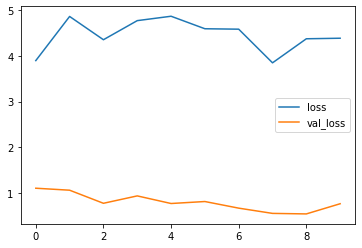

In [20]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

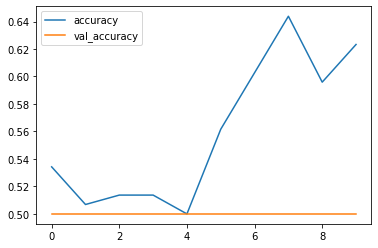

In [21]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

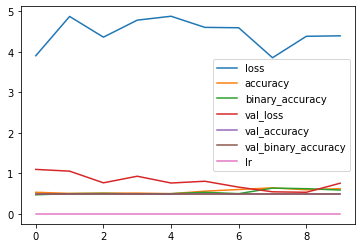

In [22]:
losses.plot()

In [23]:
model.evaluate(test_generator)

2/2 [==============================] - 16s 3s/step - loss: 0.7578 - accuracy: 0.5000 - binary_accuracy: 0.5000


[0.757847011089325, 0.5, 0.5]

predictions

In [24]:
model_pred=model.predict(test_generator)

2/2 [==============================] - 16s 3s/step


In [25]:
print(model_pred)

[[0.02606122]
 [0.00303368]
 [0.00521944]
 [0.20315619]
 [0.22675455]
 [0.20827365]
 [0.21349058]
 [0.00408553]
 [0.02715358]
 [0.23022573]
 [0.01248669]
 [0.01547504]
 [0.21141899]
 [0.25787807]
 [0.00591898]
 [0.24279971]
 [0.00670191]
 [0.01531633]
 [0.02436016]
 [0.2272441 ]
 [0.00554295]
 [0.0071221 ]
 [0.06063318]
 [0.00293399]
 [0.0105366 ]
 [0.20409192]
 [0.00403425]
 [0.00328985]
 [0.22611983]
 [0.20597759]
 [0.23525746]
 [0.34612936]
 [0.20893563]
 [0.01492391]
 [0.3403235 ]
 [0.13530159]
 [0.16261005]
 [0.01912803]
 [0.24324778]
 [0.21598443]]


In [26]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [27]:
class_names=['NORMAL','PNEUMONIA']

In [28]:
import matplotlib.pyplot as plt
import numpy as np
def plot_prediction(test_generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    images, labels = test_generator.next()
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

1/1 [==============================] - 12s 12s/step


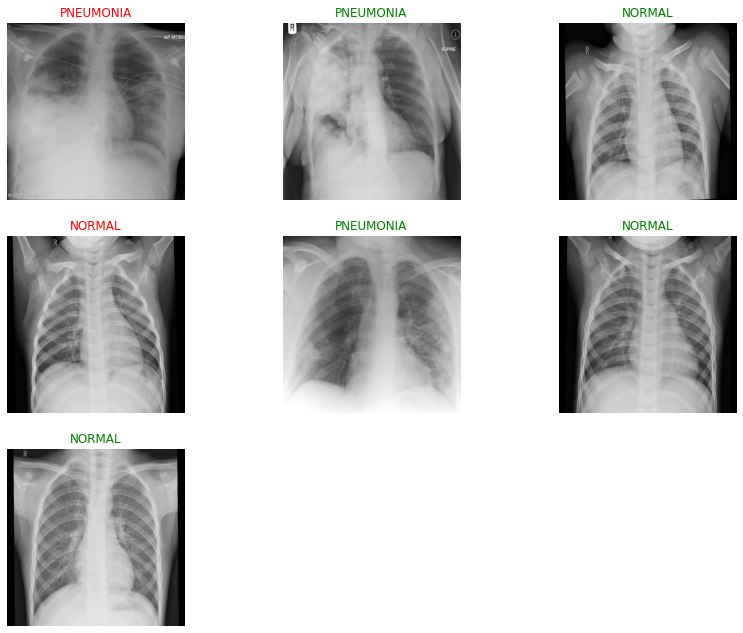

In [29]:

plot_prediction(test_generator,8)

## CONFUSION MATRIX

In [30]:
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Preparing classes' labels

In [31]:
# Defining list with labels
labels = ['NORMAL','PNEUMONIA']


# Check point
# Showing labels
print(labels)


['NORMAL', 'PNEUMONIA']


 Generating True Vector

In [32]:
# Generating Numpy array with True classes' indexes
y_true = np.random.randint(low=0, high=2, size=100, dtype=int)


# Check point
# Shwoing array
print(y_true)

[1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1
 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0
 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0]


Showing distribution of samples among classes

In [33]:
# Calculating number of samples for every class
# Iterating all classes' indexes in 'y_true' array
# Using Numpy function 'unique'
# Returning sorted unique elements and their frequencies
classesIndexes, classesFrequency = np.unique(y_true, return_counts=True)


# Printing frequency (number of samples) for every class
print('classes indexes:' , classesIndexes)
print('\n')
print('classes frequency:', classesFrequency)




classes indexes: [0 1]


classes frequency: [50 50]


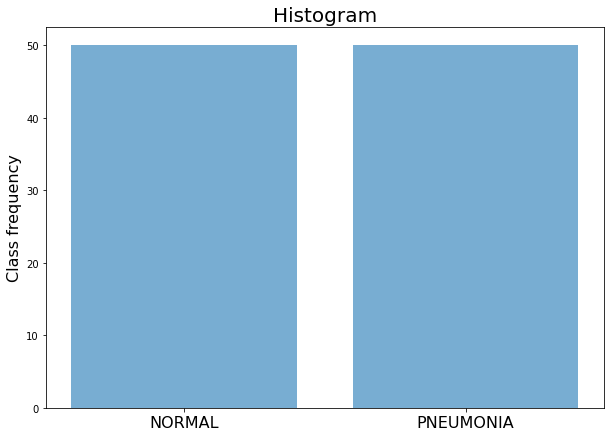

In [34]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
plt.rcParams['figure.figsize'] = (10.0, 7.0)


# Plotting histogram of 5 classes with their number of samples
# Defining a figure object 
figure = plt.figure()


# Plotting Bar chart
plt.bar(classesIndexes, classesFrequency, align='center', alpha=0.6)


# Giving name to Y axis
plt.ylabel('Class frequency', fontsize=16)
# Giving names to every Bar along X axis
plt.xticks(classesIndexes, labels, fontsize=16)


# Giving name to the plot
plt.title('Histogram', fontsize=20)


# Saving the plot
figure.savefig('histogram.png', transparent=True, dpi=500)


# Showing the plot
plt.show()

Generating Predicted Vector

In [35]:
# Making copy of array with True classes' indexes
y_predicted = np.copy(y_true)

In [36]:
# Choosing randomly 25% of classes to be changed
ii = np.random.randint(low=0, high=len(y_true), size=int(0.25 * len(y_true)), dtype=int)


# Check point
# Showing chosen indexes
print(ii)

[21  6 79  0 13 31 88 61 50 41 73 83 72 58 99 91 72  3 14 23 66 97 47 55
 85]


In [37]:
# Iterating chosen indexes and replacing them with other classes' indexes
for i in ii:
    # Generating new class index
    y_predicted[i] = np.random.randint(low=0, high=2, dtype=int)
    
    
    # Check point
    # Showing difference between True classes' indexes and Predicted ones
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.
          format(i, y_true[i], y_predicted[i]))

index = 21, True class => 0, 0 <= Predicted class
index =  6, True class => 1, 0 <= Predicted class
index = 79, True class => 1, 1 <= Predicted class
index =  0, True class => 1, 0 <= Predicted class
index = 13, True class => 1, 1 <= Predicted class
index = 31, True class => 0, 1 <= Predicted class
index = 88, True class => 1, 1 <= Predicted class
index = 61, True class => 1, 1 <= Predicted class
index = 50, True class => 1, 0 <= Predicted class
index = 41, True class => 1, 0 <= Predicted class
index = 73, True class => 0, 0 <= Predicted class
index = 83, True class => 1, 1 <= Predicted class
index = 72, True class => 0, 1 <= Predicted class
index = 58, True class => 0, 0 <= Predicted class
index = 99, True class => 0, 0 <= Predicted class
index = 91, True class => 1, 1 <= Predicted class
index = 72, True class => 0, 0 <= Predicted class
index =  3, True class => 0, 0 <= Predicted class
index = 14, True class => 0, 0 <= Predicted class
index = 23, True class => 0, 1 <= Predicted class


Calculating Confusion Matrix

In [38]:
# Confusion Matrix is a two dimensional matrix that visualizes the performance,
# and makes it easy to see confusion between classes,
# by providing a picture of interrelation

# Each row represents a number of actual, True class
# Each column represents a number of predicted class


# Computing Confusion Matrix to evaluate accuracy of classification
c_m = confusion_matrix(y_true, y_predicted)

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[48  2]
 [ 7 43]]


 Displaying Confusion Matrix

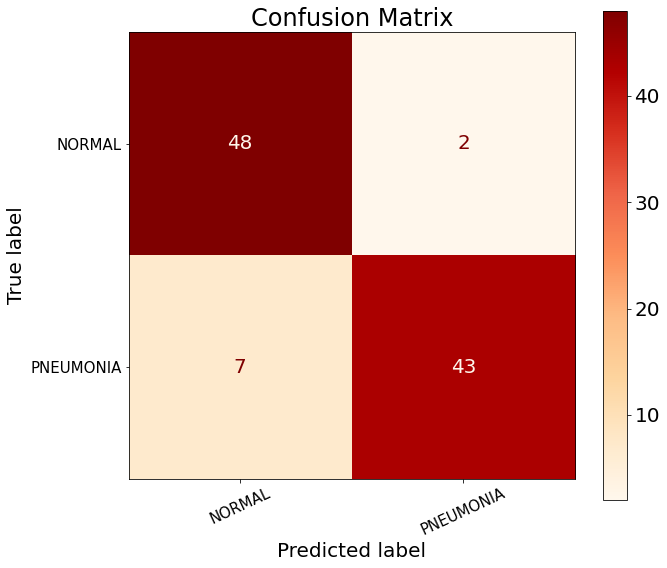

In [39]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()

In [40]:
# Showing the main classification metrics
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        50
           1       0.96      0.86      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

